In [1]:
%matplotlib inline
%run notebook_setup

# Parametric Inference with Pyro

In all of the tutorials thus far, we have used MPoL to optimize non-parametric image plane models, i.e., collections of pixels. However, there may be instances where the astrophysical source morphology is simple enough at the resolution of the data such that an investigator might wish to fit a parametric model to the data. In the protoplanetary disk field, there is a long history of parametric model fits to data. The simplest example of this would be an elliptcial Gaussian fit through CASA's [uvmodelfit](https://casadocs.readthedocs.io/en/stable/api/tt/casatasks.manipulation.uvmodelfit.html), while a more complex example might be the [Galario](https://mtazzari.github.io/galario/) package. While non-paramtetric models tend to get all of the attention in this era of Big Data, well-constructed parametric models can still prove useful thanks to their interpretability and role in Bayesian inference.

In this tutorial, we will explore how we can use MPoL with a probabilistic programming language called [Pyro](https://pyro.ai/) to perform parametric model fitting with a continuum protoplanetary disk dataset and derive posterior probability distributions of the model parameters. One major advantage of using MPoL + Pyro to do parametric model fitting compared to existing packages is that posterior gradient information is naturally provided by PyTorch's autodifferentiation capabilities. This, coupled with the industry-grade inference algorithms provided by Pyro, makes it computationally efficient to explore posterior probability distributions with dozens or even hundreds of parameters--something that would be impractical using classical MCMC algorithms.

## MPoL and models

Before we discuss the specifics of the parametric disk model, let's take a high-level look at what makes up an MPoL model 

### Non-parametric models 
Let's start by considering the architecture of the simplest possible skeleton non-parametric RML model


```{mermaid} ../_static/mmd/src/ImageCube.mmd
```

When we say that a model is non-parametric we generally mean that the number of parameters of the model is vast (potentially infinite) and can grow to encapsulate more detail if needed. A classic example is something like a spline or a Gaussian process, but in our case we are using a large number of discrete pixel fluxes to represent an image.

We can see the definition of these "non-parametric" image parameters in the Pytorch layer

```
self.cube = nn.Parameter(
    torch.full(
        (self.nchan, self.coords.npix, self.coords.npix),
        fill_value=0.0,
        requires_grad=True,
        dtype=torch.double,
    )
)
```
The `nn.Parameter` call tells Pytorch that the `cube` tensor containing the image pixels should be varied during optimization.

We can consider the architecture of the {class}`mpol.precomposed.SimpleNet` as a more practical extension 


```{mermaid} ../_static/mmd/src/SimpleNet.mmd
```

The functionality of the {class}`mpol.precomposed.SimpleNet` is similar to the skeleton model, but we've shifted the base parameterization from the {class}`mpol.images.ImageCube` to the {class}`mpol.images.BaseCube` (so that pixel flux values are non-negative) and we've included a small convolution kernel (through {class}`mpol.images.HannConvCube`) so that high-spatial-frequency noise is supressed. In this framework, the `nn.Parameter`s are instantiated on the {class}`~mpol.images.BaseCube` and the {class}`~mpol.images.ImageCube` becomes a pass-through layer.

In both of these cases, the key functionality provided by the MPoL package is the {class}`mpol.fourier.FourierCube` layer that translates a model image into the visibility plane. From the perspective of the {class}`~mpol.fourier.FourierCube`, it doesn't care how the model image was produced, it will happily translate image pixels into visibility values using the FFT.

### Parametric models

By contrast to a non-parametric model, a *parametric* model is one that has a (finite) set of parameters (generally decoupled from the size of the data) and can be easily used to make future predictions of the data, usually in a functional form. For example, a cubic function and its coefficients would be considered a parametric model. For a radio astronomy example, you can think of the {class}`~mpol.images.BaseCube` and {class}`mpol.images.HannConvCube` layers as being replaced by a parametric disk model, which we'll call `DiskModel`. This parametric model would specify pixel brightness as a function of position based upon model parameters, and would feed directly into the {class}`~mpol.images.ImageCube` pass-through layer.

```{mermaid} ../_static/mmd/src/Parametric.mmd
```

Before ALMA, it was common in the protoplanetary disk field to fit parametric models (e.g., elliptical Gaussians, one or two axisymmetric rings, etc...) to interferometric observations to derive source properties like size and inclination. The spatial resolution afforded by the ALMA long-baseline campaign rendered many of these simple parametric models inadequate. Suddenly, rich substructure in the forms of rings, gaps, and spirals was visible in dust continuum images and, except for a few exceptions we'll discuss in a second, these morphologies were too complex to neatly capture with simple model parameterizations.

This spurred a major shift from parametric, visibility-based analyses to image-based analysis (including our own MPoL efforts). For axisymmetric sources, visibility-based analysis is still viable thanks to the development of novel non-parametric 1D models like [frank](https://discsim.github.io/frank/), which are capable of super-resolution compared to image-based methods like CLEAN.

In our opinion, the two (linked) reasons that parametric model fitting has fallen out of favor in the protoplanetary disk field are 

1. ALMA data are sufficiently high quality that many model parameters are required to accurately describe disk emission
2. standard sampling algorithms used for Bayesian inference do not perform well in high dimensional parameter spaces

As we hinted at, the MPoL + Pyro + PyTorch framework will help us out on point #2, such that we might be able to explore more detailed models with larger numbers of parameters.

This point of this tutorial isn't to say that actually everyone should switch back to using parametric models. But rather, that, with the industry-grade machinery of probabilistic programming languages and autodifferentiation, there may be situations where parametric models are still useful.

## DSHARP AS 209 dataset

For this tutorial we'll use the ALMA DSHARP dust continuum observations of the AS 209 protoplanetary disk. The data reduction is described in [Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract) and the primary analysis is described in [Guzmán et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..48G/abstract).

The original measurement sets from the DSHARP program are available in measurement set format from the ALMA project pages (e.g., [NRAO](https://bulk.cv.nrao.edu/almadata/lp/DSHARP/)). To save some boilerplate code and computation time for the purposes of this tutorial, we have extracted the visibilities from this measurement set, performed a few averaging and weight scaling steps, and uploaded the processed dataset to a Zenodo [repository](https://zenodo.org/record/7732834#.ZBCKAexKhhE) as an [asdf](https://asdf.readthedocs.io/en/stable/index.html) file. The full set of pre-processing commands are available in the [mpoldatasets package](https://github.com/MPoL-dev/mpoldatasets/tree/main/products/AS209-DSHARP-continuum-averaged). Let's download the file and extract the visibilities

In [2]:
from astropy.utils.data import download_file

fname = download_file(
    "https://zenodo.org/record/7732834/files/AS209_continuum_averaged.asdf",
    cache=True,
    pkgname="mpol",
)

In [3]:
import asdf 

# load extracted visibilities from asdf file 
d = asdf.open(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]    

Let's use the MPoL {class}`~mpol.gridding.DirtyImager` to make some diagnostic images, to make sure we've loaded the data correctly.

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

from mpol import coordinates, gridding

# settle on an image size that we'll use throughout the tutorial
coords = coordinates.GridCoords(cell_size=0.005, npix=800)
kw = {"origin": "lower", "interpolation": "none", "extent": coords.img_ext}


def make_dirty_image(data_real, data_imag, robust=-0.5):
    """
    Make a plot of the dirty beam and dirty image (in units of Jy/arcsec^2).
    
    Args:
        data_real (numpy array): real components of visibilities
        data_imag (numpy array): imaginary components of visibilities
        robust (float): the Briggs robust parameter
        
    Returns:
        beam, image numpy arrays
    """

    imager = gridding.DirtyImager(
        coords=coords,
        uu=uu,
        vv=vv,
        weight=weight,
        data_re=data_real,
        data_im=data_imag,
    )

    return imager.get_dirty_image(weighting="briggs", robust=robust, unit="Jy/arcsec^2")

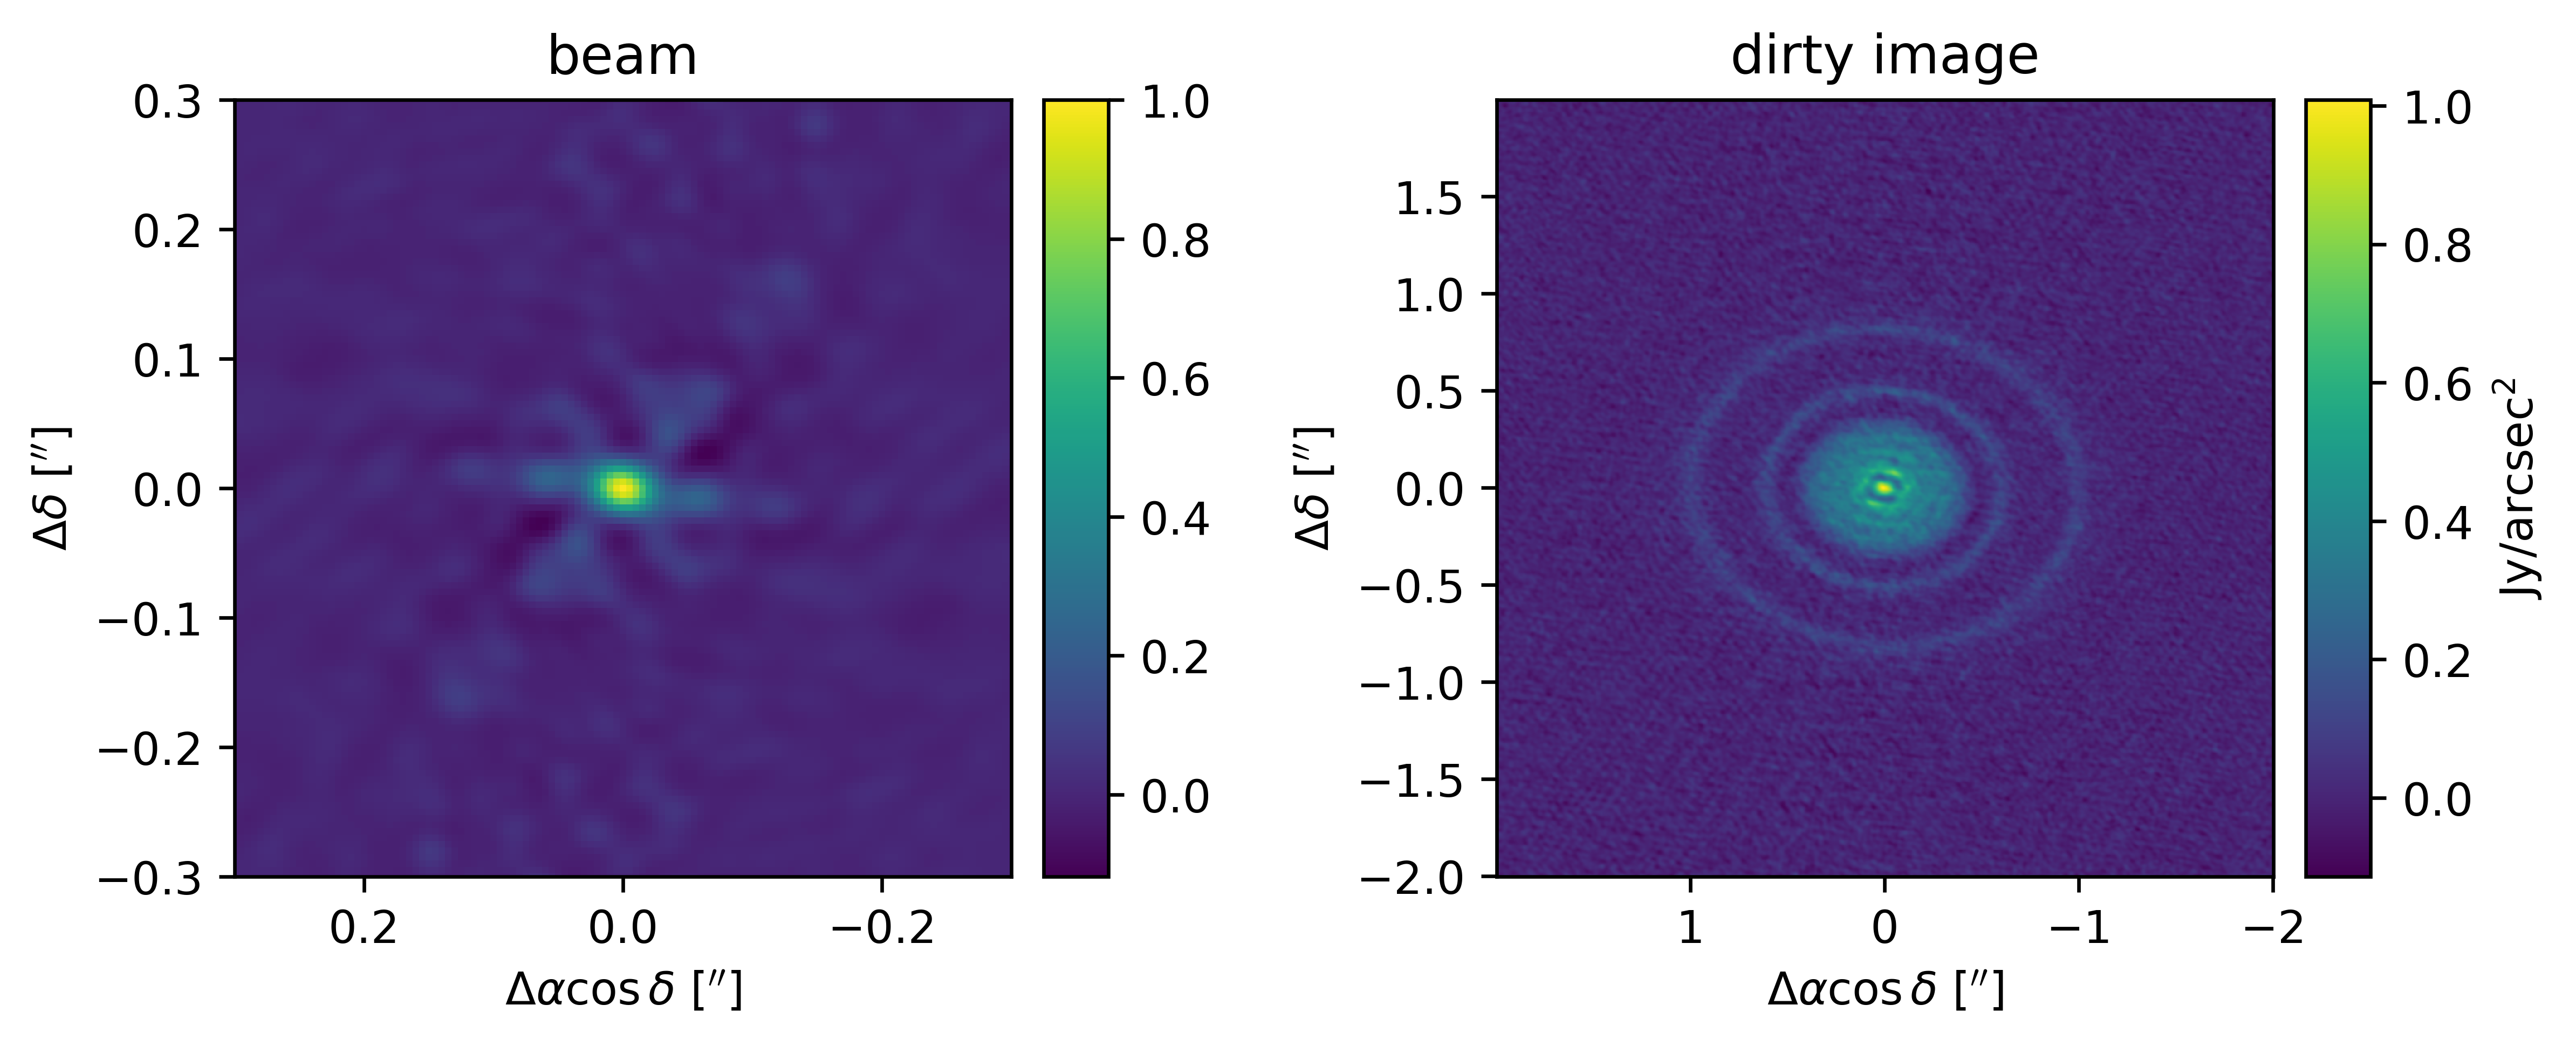

In [5]:
img, beam = make_dirty_image(np.real(data), np.imag(data))

# set plot dimensions
xx = 8 # in
cax_width = 0.2 # in 
cax_sep = 0.1 # in
mmargin = 1.2
lmargin = 0.7
rmargin = 0.7
tmargin = 0.3
bmargin = 0.5

npanels = 2
# the size of image axes + cax_sep + cax_width
block_width = (xx - lmargin - rmargin - mmargin * (npanels - 1) )/npanels
ax_width = block_width - cax_width - cax_sep
ax_height = ax_width 
yy = bmargin + ax_height + tmargin

fig = plt.figure(figsize=(xx, yy))
ax = []
cax = []
for i in range(npanels):
    ax.append(fig.add_axes([(lmargin + i * (block_width + mmargin))/xx, bmargin/yy, ax_width/xx, ax_height/yy]))
    cax.append(fig.add_axes([(lmargin + i * (block_width + mmargin) + ax_width + cax_sep)/xx, bmargin/yy, cax_width/xx, ax_height/yy]))

# single-channel image cube    
chan = 0

im_beam = ax[0].imshow(beam[chan], **kw)
cbar = plt.colorbar(im_beam, cax=cax[0])
ax[0].set_title("beam")
# zoom in a bit
r = 0.3
ax[0].set_xlim(r, -r)
ax[0].set_ylim(-r, r)

im = ax[1].imshow(img[chan], **kw)
ax[1].set_title("dirty image")
cbar = plt.colorbar(im, cax=cax[1])
cbar.set_label(r"Jy/$\mathrm{arcsec}^2$")

for a in ax:
    a.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    a.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

In their DSHARP paper, Guzmán et al. 2018 noted the striking azimuthal symmetry of the AS 209 disk. This motivated them to develop and fit a 1D surface brightness profile $I(r)$ using a series of concentric Gaussian rings of the form

$$
I(r) = \sum_{i=0}^N A_i \exp \left (- \frac{(r - r_i)^2}{2 \sigma_i^2} \right).
$$

The axisymmetry of the model allowed them to use the Hankel transform to compute the visibility function $\mathcal{V}$ corresponding to a given $I(r)$. The Hankel transform also plays a key role in non-parametric 1D methods like `frank`. Guzmán et al. 2018 evaluated the probability of the data given the model visibilities using a likelihood function and assigned prior probability distributions to their model parameters. They used the [emcee](https://emcee.readthedocs.io/) MCMC ensemble sampler to sample the posterior distribution of the parameters and thus infer the surface brightness profile $I(r)$. 

In what follows we will use Pyro and the MPoL framework to implement the same concentric Gaussian ring model as Guzmán et al. 2018 and (hopefully) verify that we obtain the same result. But, we should note that because MPoL uses the 2D FFT to perform the Fourier Transform, we do not need to assume an axisymmetric model. This may be beneficial when fitting disk morphologies that are not purely axisymmetric.

## Introduction to Probabilistic Programming Languages

Many astronomers usually follow an MCMC analysis pathway similar to Guzmán et al. 2018: they write custom code to implement their model, calculate their likelihood function and priors, and then use an MCMC package like `emcee` to sample the posterior. 

[Probabilistic programming languages](https://en.wikipedia.org/wiki/Probabilistic_programming) (PPLs)
are by no means a recent invention, but have in recent years become much more powerful and scientifically capable thanks to the integration of autodifferentiation and advanced sampling methodologies that use gradient information. In our own subfield, we are most familiar with the [exoplanet](https://docs.exoplanet.codes/en/latest/) codebase, built on PyMC3; however, a quick search on ADS demonstrates that probabilistic programming languages have seen greater usage by astronomers in the past decade across a variety of subfields. 

Simply put, PPLs are frameworks that help users build statistical models and then infer/optimize the parameters of those models conditional on some dataset. PPLs usually have their own learning curve that requires familiarizing oneself with the syntax of the language and the mechanics of building models; once the learning curve is climbed, however, PPLs have the potential to be incredibly powerful inference tools.

[Pyro](https://pyro.ai/) is the main PPL built on PyTorch, so that is what we will use in this tutorial. In what follows we'll try to explain the relevant parts of Pyro that you'll need to get started, but a full introduction to Pyro and PPLs is beyond the scope of this tutorial. If you are interested, we recommend you see the following resources: 

* [Introduction to Pyro](http://pyro.ai/examples/intro_long.html)
* [Bayesian Regression - Introduction](http://pyro.ai/examples/bayesian_regression.html)

The Pyro [examples](http://pyro.ai/examples/index.html) page and [documentation](https://docs.pyro.ai/en/stable/) have much more information that can help you get started.

We also recommend reading Gelman et al. 2020's paper on [Bayesian Workflow](https://arxiv.org/abs/2011.01808). It contains very useful advice on structuring a large and complex Bayesian data analysis problem and will no doubt save you time when constructing your own models.

If you are new to Bayesian analysis in general, we recommend that you put this tutorial aside for a moment and review some introductory resources like [Eadie et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230204703E/abstract) and references therein.

## Building a parametric disk model 

There are many ways to build a Pyro model. In this tutorial we will take a class-based approach and use the [PyroModule](http://pyro.ai/examples/modules.html) construct, but models can just as easily be built using function definitions (for [example](http://pyro.ai/examples/intro_long.html#Models-in-Pyro)).

In [6]:
import torch
from torch import nn
from mpol import geometry, gridding, images, fourier, utils
from mpol.constants import deg
from mpol.datasets import index_vis

import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method

First, we'll define a class that we'll call `PyroDisk`. This class defines Guzmán et al. 2018's ringed model using the Pyro PPL and produces an image.

In [7]:
class PyroDisk(PyroModule):
    r"""
    This routine returns an image.
    """

    def __init__(
        self,
        coords=None,
        nchan=1,
        distance=None,
    ):
        super().__init__()

        self.coords = coords
        self.nchan = nchan

        # observer-frame coordinates
        YY = torch.as_tensor(self.coords.packed_x_centers_2D.copy())
        XX = torch.as_tensor(self.coords.packed_y_centers_2D.copy())
        self.register_buffer("YY", YY)
        self.register_buffer("XX", XX)
        # This mashup is because of the way we define the coordinate system for orbital elements.
        # YY points north
        # XX points east

        # setup geometric parameters

        # the model is axisymmetric, so argument of periastron is degenerate. We set this to 0 and 
        # do not sample in it.
        self.omega = 0 

        # we have a reasonably good guess as to these orientations from inspection of the 
        # dirty image and so Normal priors are fine. 
        # If we were very uncertain about these parameters, it might make sense using 
        # the Von Mises distribution for the angles like omega, incl, and Omega
        # https://docs.pyro.ai/en/stable/distributions.html?highlight=constraints#vonmises
        # https://en.wikipedia.org/wiki/Von_Mises_distribution
        self.incl = PyroSample(dist.Normal(35. * deg, 5. * deg))
        self.Omega = PyroSample(dist.Normal(85.0 * deg, 10.0 * deg))
        
        # to treat parameters as fixed, simply asign them as torch tensors
        # for example,
        # self.x_centroid = torch.as_tensor(x_centroid)  # arcsec
        # self.y_centroid = torch.as_tensor(y_centroid)  # arcsec

        self.x_centroid = PyroSample(dist.Normal(0.0, 3e-3)) # arcsec
        self.y_centroid = PyroSample(dist.Normal(0.0, 3e-3)) # arcsec

        self.distance = torch.as_tensor(distance)  # pc

        # Define a 1D radial grid for evaluating the 1D intensity profile
        self.R = torch.linspace(0.0, torch.max(torch.concat([XX, YY])), steps=200) * self.distance

        self.log_A_0 = PyroSample(dist.Normal(0.0, 0.3))
        self.log_sigma_0 = PyroSample(dist.Normal(0.7, 0.1))
    
        # list of Gaussian parameters
        # ring means from Huang et al. 2018a.
        ring_means = torch.as_tensor(np.array([14., 28., 41., 74., 99., 120., 141.]))
        self.nrings = torch.as_tensor(len(ring_means))

        self.log_ring_sigmas = PyroSample(
            dist.Normal(0.8, 0.3).expand([self.nrings]).to_event(1)
        )

        self.log_ring_amplitudes = PyroSample(
            dist.Normal(-1.0, 0.5).expand([self.nrings]).to_event(1)
        )

        # we set the mean of the Normal prior on the ring means to the values from Huang
        self.ring_means = PyroSample(dist.Normal(ring_means, 10.0).to_event(1))
            

    @pyro_method
    def _Gaussian(self, r, A_i, r_i, sigma_i):
        r"""
        Evaluate a Gaussian ring of the form

        .. math::

            f(r) = A_i \exp \left(- \frac{(r - r_i)^2}{2 \sigma_i^2} \right)
        """
        return A_i * torch.exp(-0.5 * (r - r_i) ** 2 / sigma_i**2)

    @pyro_method
    def intensity_profile(self, r):
        r"""
        Evaluate the intensity profile.
        """
        I = torch.zeros_like(r)

        # evaluate the central Gaussian
        A_0 = torch.pow(10.0, self.log_A_0)
        r_0 = 0.0
        sigma_0 = torch.pow(10.0, self.log_sigma_0)

        I += self._Gaussian(r, A_0, r_0, sigma_0)

        # evaluate the rings
        for i in range(self.nrings):
            A_i = torch.pow(10.0, self.log_ring_amplitudes[i])
            r_i = self.ring_means[i]
            sigma_i = torch.pow(10.0, self.log_ring_sigmas[i])
            I += self._Gaussian(r, A_i, r_i, sigma_i)

        return I

    def forward(self):
        # take 2D coords object and project it to 2D frame
        # units of arcseconds
        x_warped, y_warped = geometry.observer_to_flat(
            self.XX, self.YY, omega=self.omega, incl=self.incl, Omega=self.Omega
        )

        # apply centroid offset
        xx = x_warped - self.x_centroid
        yy = y_warped - self.y_centroid

        # convert x,y to radial coordinates and then to AU
        rr = torch.hypot(xx, yy) * self.distance  # [AU]

        # evaluate the 2D images against the profile
        # to create an image cube
        II = torch.unsqueeze(self.intensity_profile(rr), 0)

        # store deterministic variables for later predictive tests
        # 1D profiles 
        self.iprofile1D = pyro.deterministic("iprofile1D", self.intensity_profile(self.R))

        # 2D images
        self.sky_cube = pyro.deterministic(
            "sky_cube", utils.packed_cube_to_sky_cube(II)
        )

        # convert from Jy/arcsec^2 to Jy/pixel by multiplying by cell_size^2
        self.total_flux = pyro.deterministic(
            "total_flux", self.coords.cell_size**2 * torch.sum(II)
        )

        # packed image with extra channel dimension
        return II


We've gone ahead and defined many of our model parameters as latent random variables using `PyroSample`. We define the prior distribution on these parameters is defined by the `dist...`. For example, with the 

```
self.log_A_0 = PyroSample(dist.Normal(0.0, 0.3))
```
line we've defined the prior on the `log_A_0` parameter to be a Normal distribution with mean 0.0 and standard deviation of 0.3. 

We have also used multivariate parameters to describe the features of the rings. For example, 

```
self.log_ring_sigmas = PyroSample(
    dist.Normal(0.8, 0.3).expand([self.nrings]).to_event(1)
)
```
has set the prior distribution on each of the (logarithm of the) ring widths to be a Normal distribution with mean of 0.8 and standard deviation of 0.3. Not including the central Gaussian blob, we have 7 rings in this model. The `.expand()` call turns a Normal distribution with a shape of `1` into a distribution with a *batch* shape of 7. This isn't quite what we want in this application, so the `to_event()` call converts the *batch* shape into the *event* shape. For more details on Pyro tensor shapes, we recommend reading the [Tensor shapes in Pyro tutorial](https://pyro.ai/examples/tensor_shapes.html).


When starting out building a new model, we recomend starting out by introducing a set of latent random variables with `PyroSample` one by a few and fixing most parameters (by simply defining them as torch tensors, as noted in the comments in the above code). 

### Prior predictive check

Following the advice in [Bayesian Workflow](https://arxiv.org/abs/2011.01808), we'll first test out this model using a *prior predictive check*. This is where we generate random samples from each of the prior distributions and use them to produce versions of the model, in this case, random images of disks with 7 rings. This step is very useful because it helps you identify obvious implementation errors with our model. For example, one design flaw we spotted with an earlier iteration was when we used Normal priors on the ring amplitudes and widths. Both of these values should be positive-valued, which motivated our shift to using Normal priors on the logarithm of the ring amplitudes and widths.

In [8]:
# parameters from Guzman     
distance = 121.0  # pc

# initialize the model 
disk_pyro = PyroDisk(coords=coords, distance=distance)

To generate samples from the prior we'll use Pyro's [predictive](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.predictive) tool

In [9]:
from pyro.infer import Predictive

In [10]:
# initialize a Predictive object, do not condition on any posterior_samples
prior_predictive = Predictive(disk_pyro, num_samples=10)
# call the object to get prior predictive samples
output = prior_predictive()

Now let's examine the dictionary of output

In [11]:
output.keys()

dict_keys(['incl', 'Omega', 'x_centroid', 'y_centroid', 'log_A_0', 'log_sigma_0', 'log_ring_amplitudes', 'ring_means', 'log_ring_sigmas', 'iprofile1D', 'sky_cube', 'total_flux'])

We see that we now have a dictionary with a list of 10 random samples from the prior. We have the latent random variables that we specified, but we also have the deterministic variables like the 1D profile, total flux, and sky cube. Let's plot up 4 of these sky cubes to get a sense of what we're dealing with.

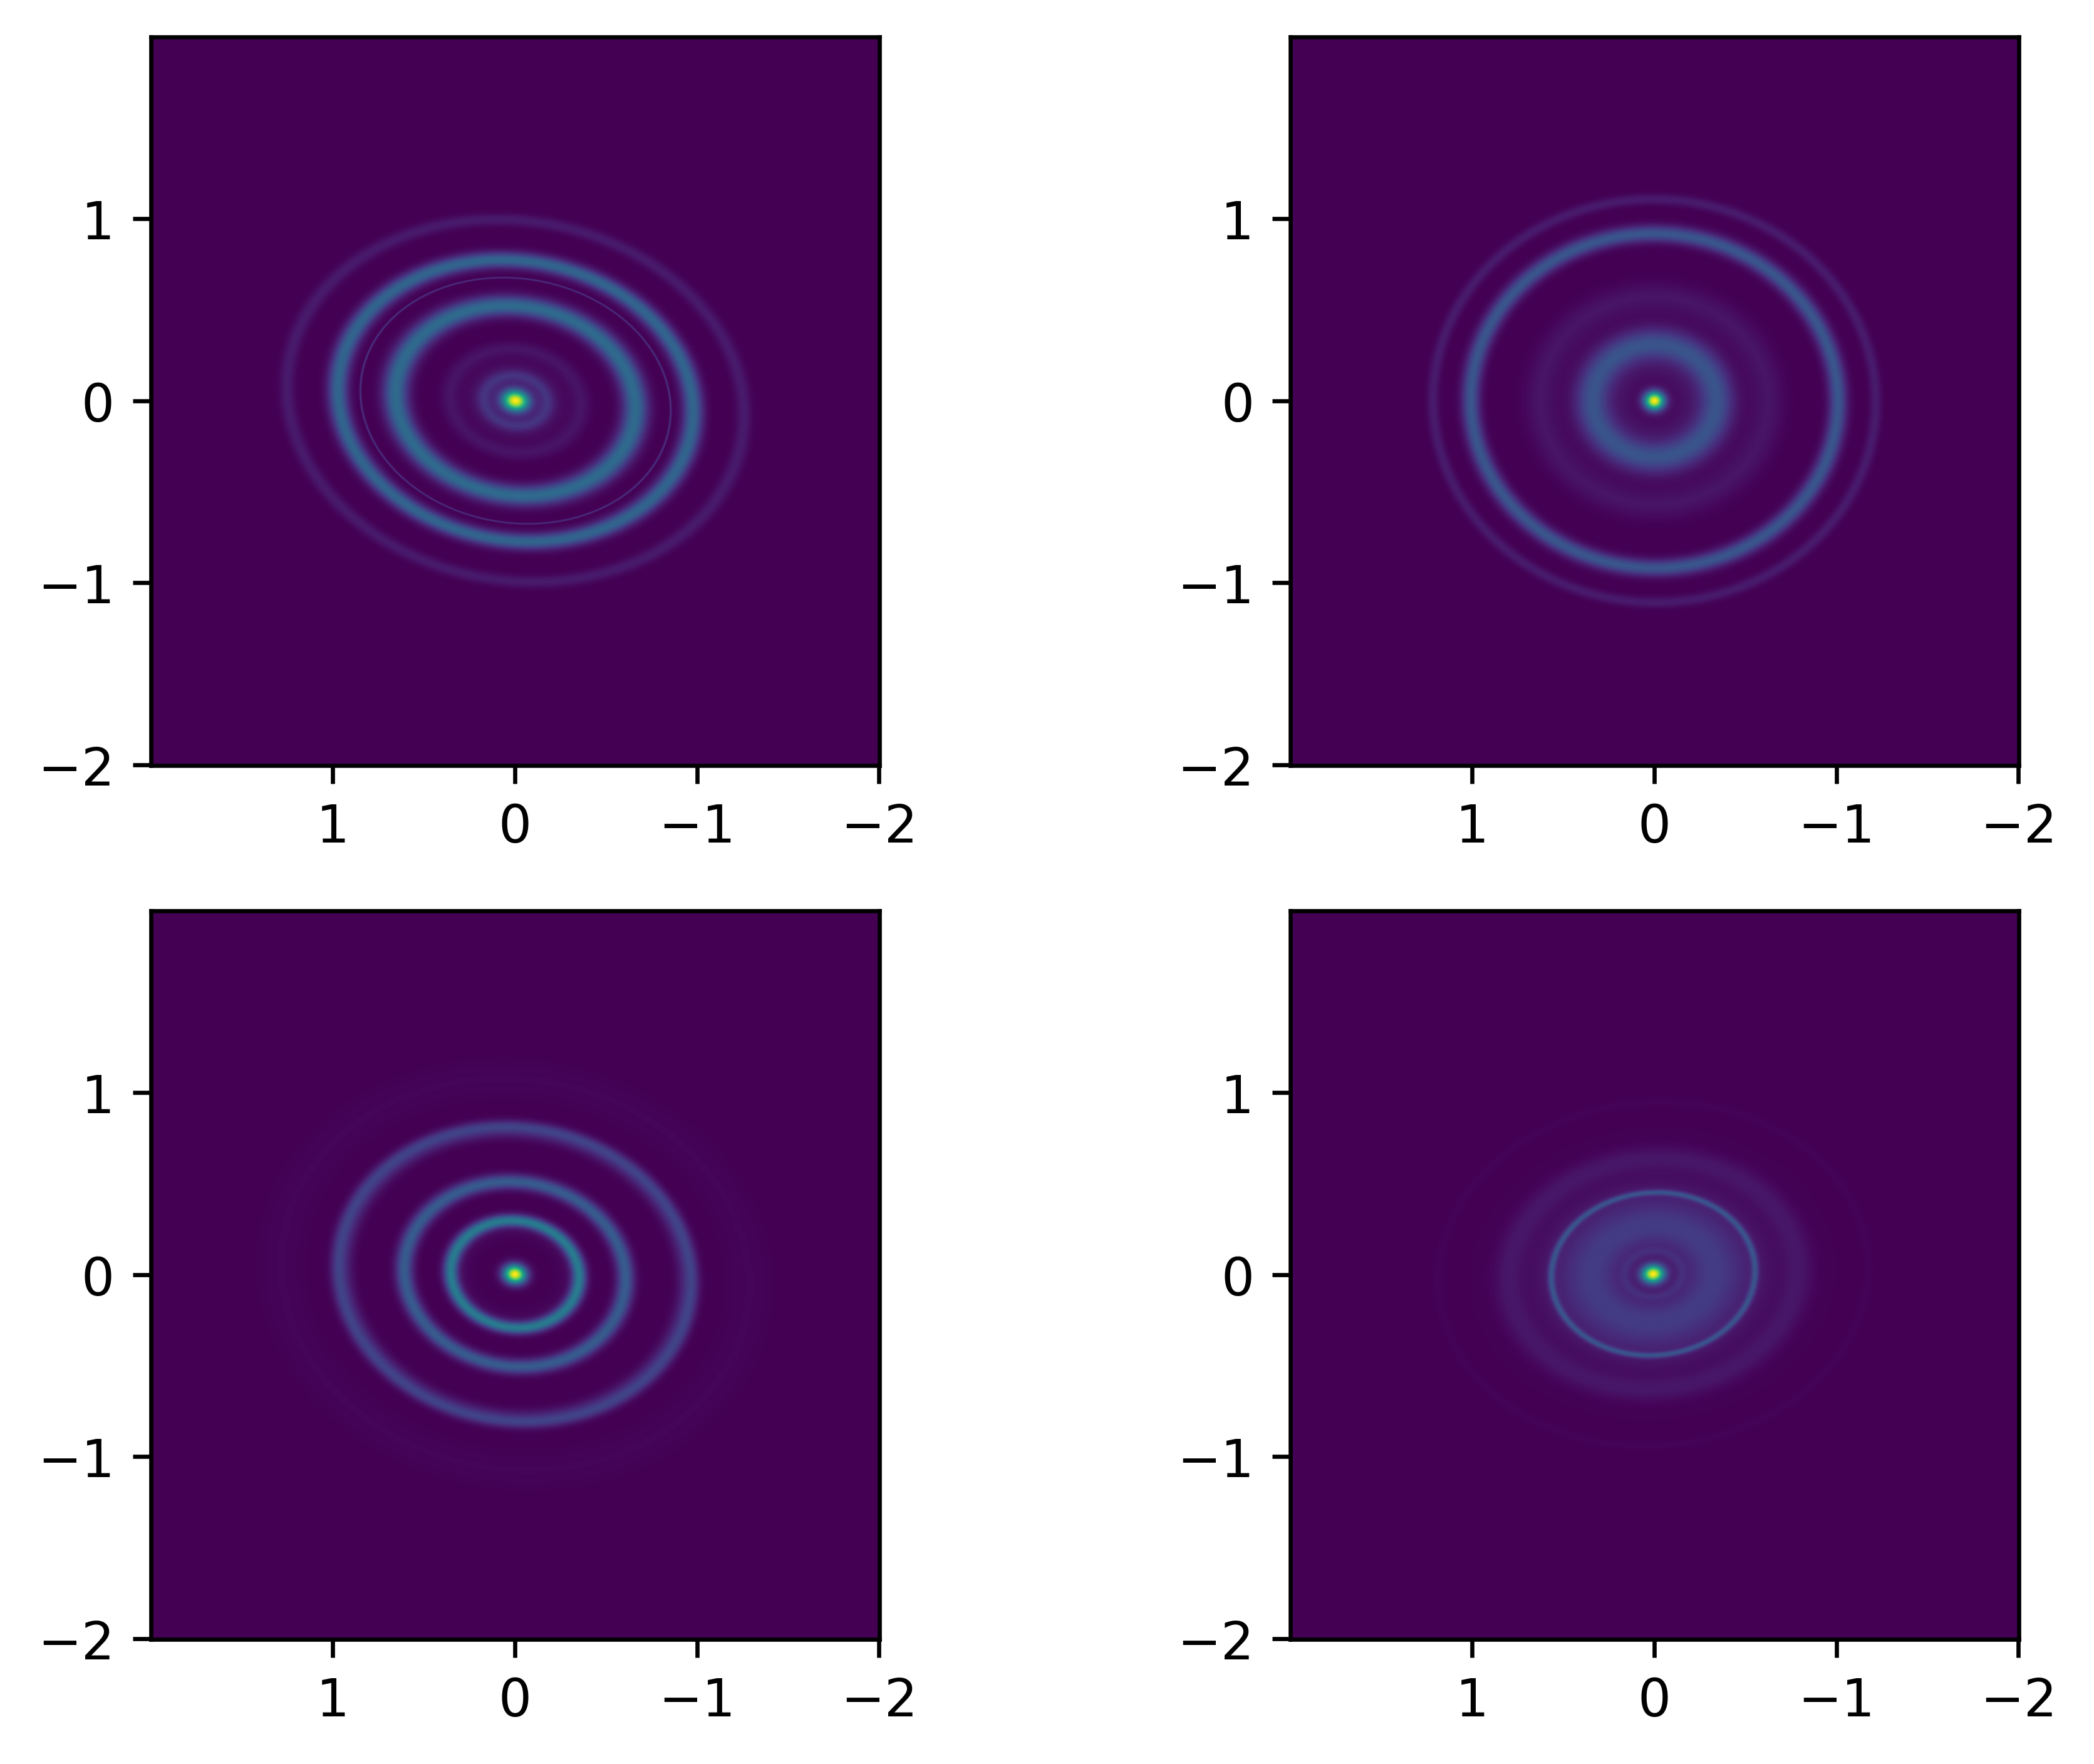

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for i, a in enumerate(ax.flatten()):
    a.imshow(output["sky_cube"][i][chan], origin="lower", extent=coords.img_ext)
    
plt.tight_layout()

And we can visualize the 1D profiles

In [13]:
output["iprofile1D"].shape

torch.Size([10, 200])

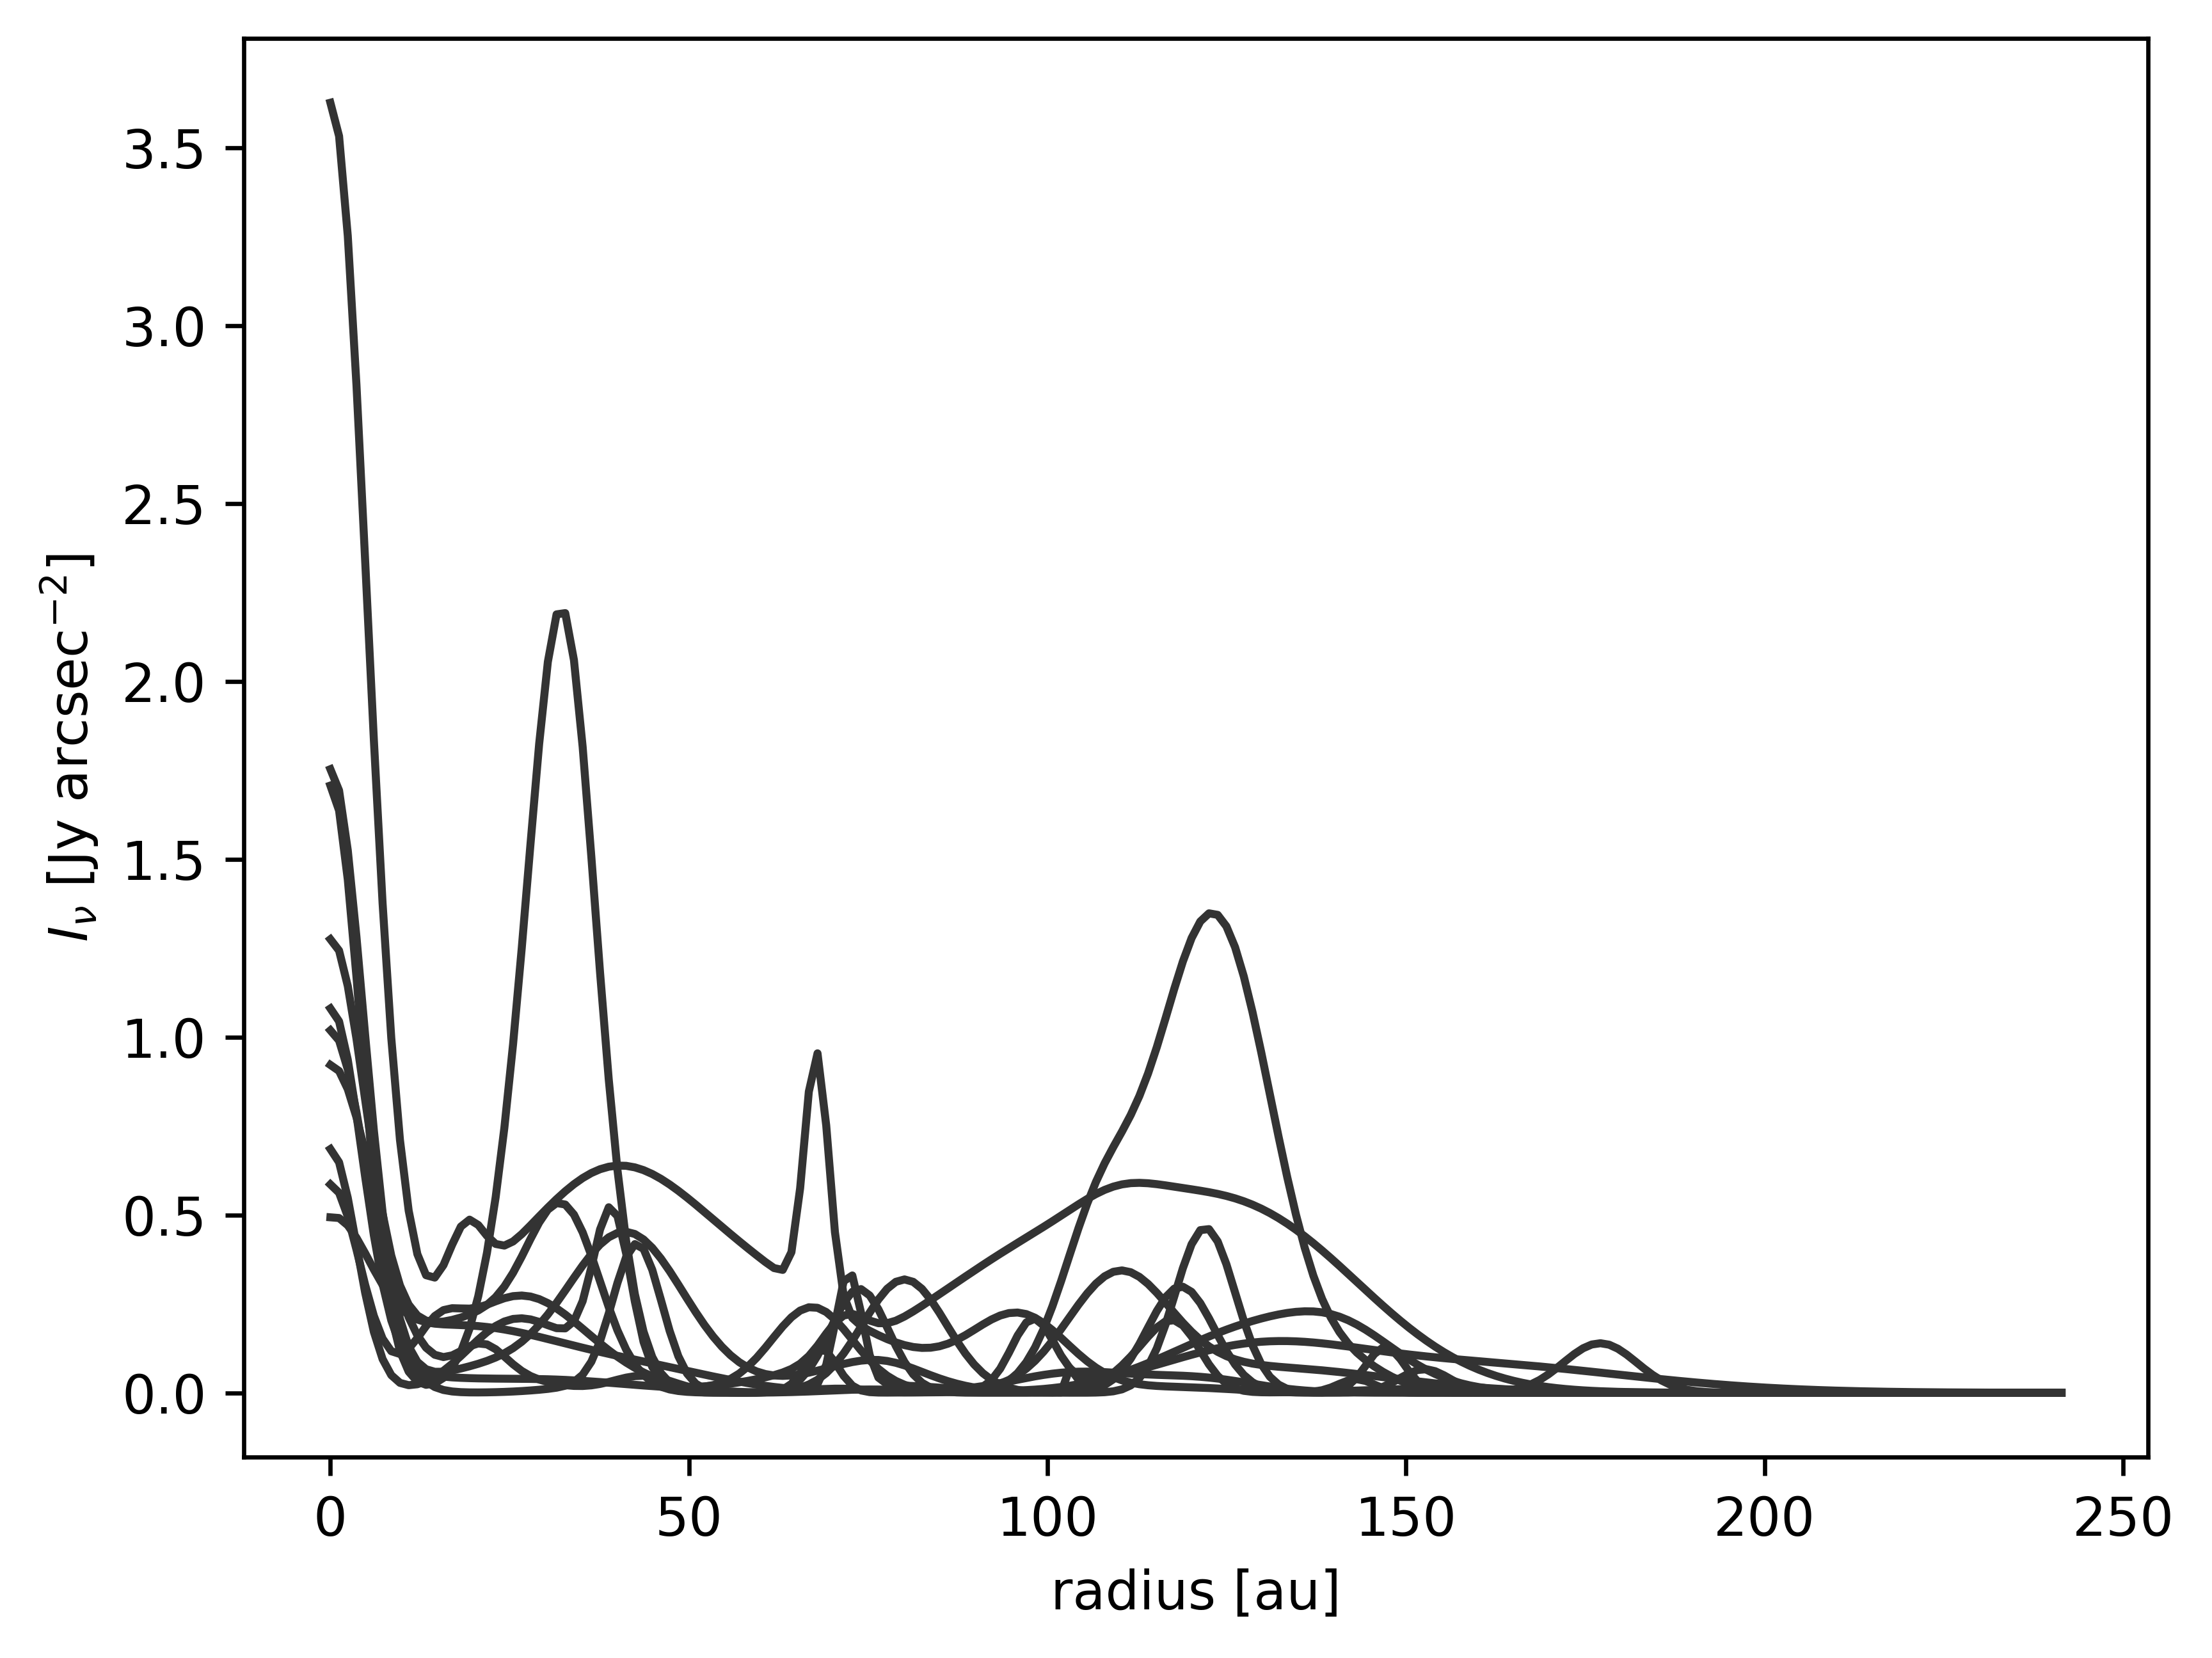

In [14]:
fig, ax = plt.subplots(nrows=1)

for profile in output["iprofile1D"]:
    ax.plot(disk_pyro.R, profile, color="0.2")
    
ax.set_xlabel("radius [au]")
ax.set_ylabel(r"$I_\nu$ [Jy $\mathrm{arcsec}^{-2}$]");

Obviously these look nothing like the actual AS 209 disk, and that's OK, these are just samples from the prior distribution. The model hasn't touched any data yet! What is reassuring is that the posterior predictions look like *plausible* disks. For example, they are in roughly the center of the field, there are no negative flux values, inclination and position angle $\Omega$ behave as they should, etc.

Before we move on, though, it would be good to check that we can reproduce a disk that does look like the AS 209 disk using the posterior distributions inferred by Guzmán et al. 2018. To do this we'll use `Predictive` conditioned on a "sample" from the posterior. In reality, we'll just take the maximum a posteriori (MAP) values reported by Guzmán et al. 2018 and treat this as a single sample. Samples are generally reported from the `Predictive` routine as a dictionary of PyTorch tensor arrays, each with length `nsamples`. So we'll need to mimic this structure when providing the Guzmán values to the `posterior_samples` argument.

In [15]:
guzman_values = {'x_centroid': torch.tensor([1.70e-3]),
                'y_centroid': torch.tensor([-3.1e-3]),
                'log_A_0': torch.log10(torch.tensor([1.0])),
                'log_sigma_0': torch.log10(torch.tensor([6.69])), 
                'log_ring_amplitudes': torch.log10(torch.tensor(np.array([[0.274, 0.133, 0.115, 0.074, 0.004, 0.051, 0.008]]))), 
                'ring_means': torch.as_tensor(np.array([[15.13, 27.07, 41.42, 74.08, 91.76, 120.42, 139.06]])), 
                'log_ring_sigmas': torch.log10(torch.tensor(np.array([[7.41, 11.72, 17.40, 7.34, 23.39, 9.84, 23.10]]))),
                 'incl': torch.tensor([34.88 * deg]),
                 'Omega': torch.tensor([85.764 * deg]),
               }

# initialize a Predictive object, condition on the Guzman "posterior sample"
prior_predictive_conditional = Predictive(disk_pyro, posterior_samples=guzman_values, num_samples=1)
output = prior_predictive_conditional()

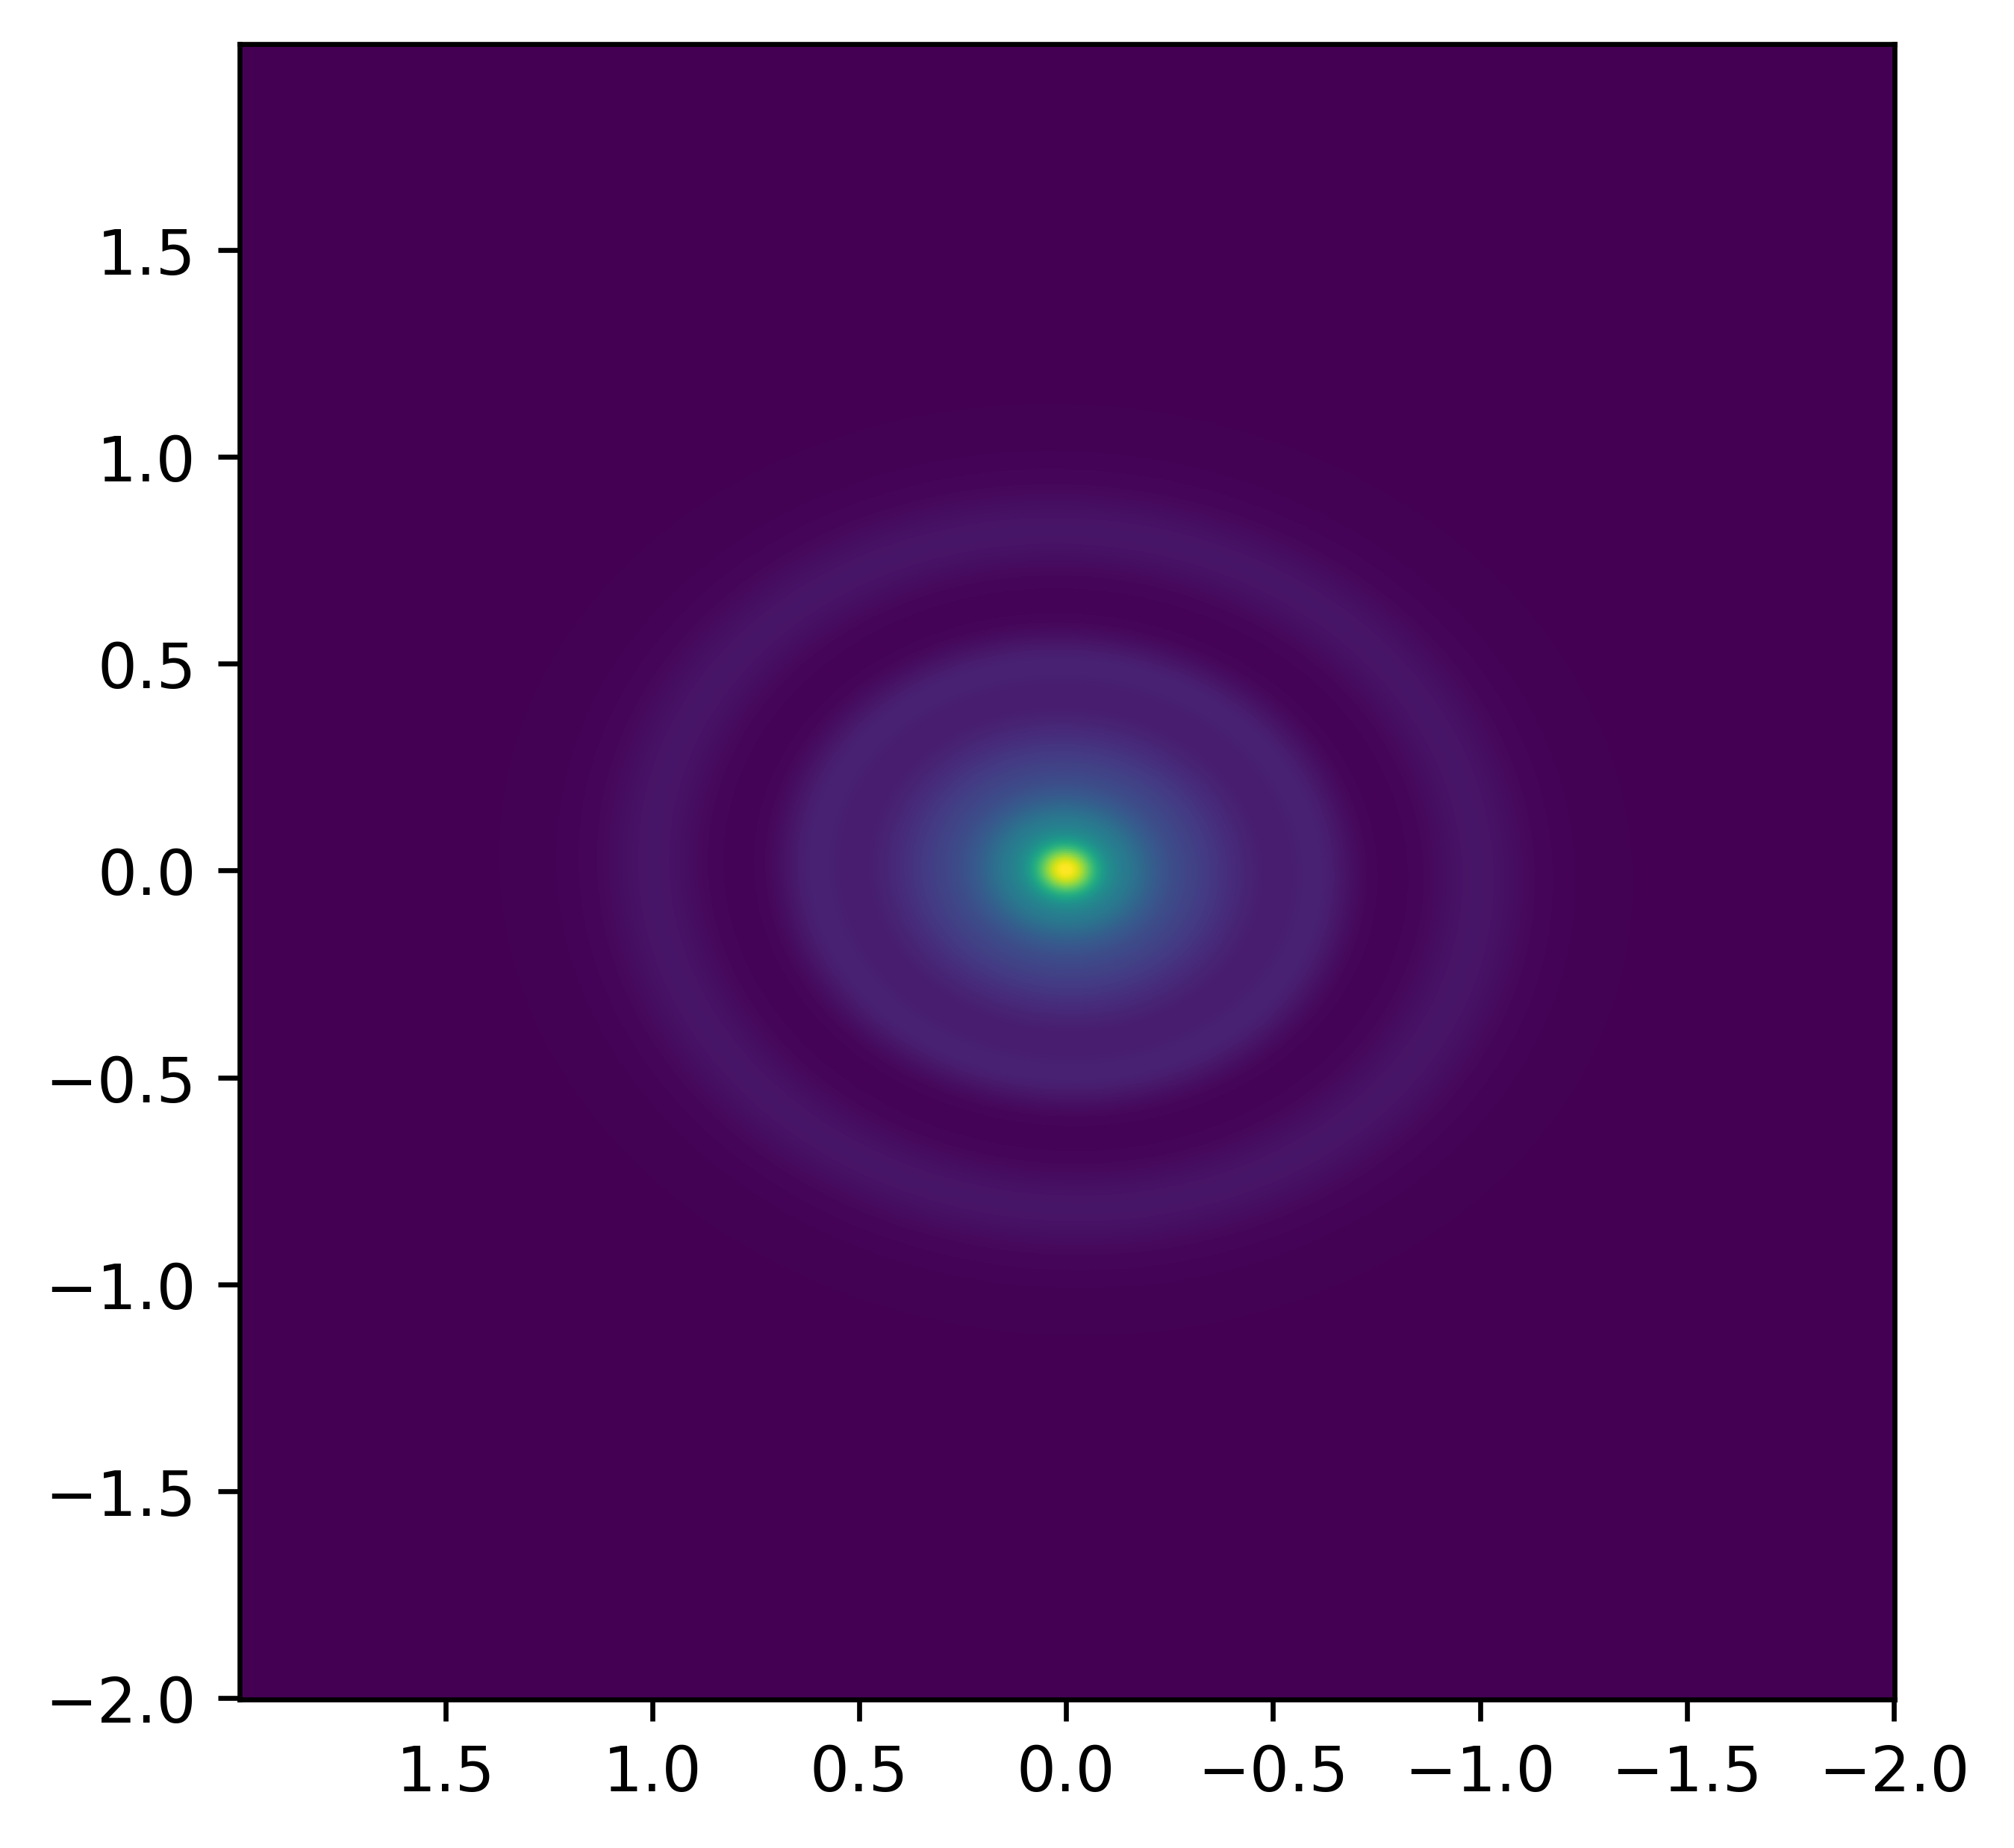

In [16]:
fig, ax = plt.subplots(nrows=1)
ax.imshow(output["sky_cube"][0][chan], origin="lower", extent=coords.img_ext);

Once you have the prior predictive and posterior predictive routines working smoothly, and you are relatively sure you've ironed out any bugs in your model composition, then it makes sense to expand the number of latent random variables.

### Incorporating the data 

Next, we'll define another class called `GriddedVisibilityModel`. This class has an instance of `PyroDisk` as an attribute and takes the image produced by that all the way to the data and evaluates the likelihood function. We could have incorporated all of the functionality inside a single class, but we thought it was cleaner to separate the functionality this way: `PyroDisk` contains the functionality specific to producing images from the Guzmán et al. 2018 model while `GriddedVisibilityModel` contains the functionality for producing and evaluating model visibilities.

In [17]:
class GriddedVisibilityModel(PyroModule):
    """
    This bigger inherits from the PyroDisk model, which provided Bayesian parameters for the disk model, and extends it to carry the comparison all the way to the data, and evaluates a likelihood.

    This will hold the dataset and weights, as well.
    """

    def __init__(
        self,
        coords=None,
        nchan=1,
        distance=None,
        uu=None,
        vv=None,
        weight=None,
        data=None,
        device=None
    ):
        super().__init__()

        # instantiate the PyroDisk as an attribute to this model
        self.disk = PyroDisk(
            coords=coords,
            nchan=nchan,
            distance=distance,
        )

        # store relevant coords objects
        self.coords = coords
        self.nchan = nchan

        # send the loose data through a DataAverager
        averager = gridding.DataAverager(
            coords=coords,
            uu=uu,
            vv=vv,
            weight=weight,
            data_re=np.real(data),
            data_im=np.imag(data),
        )
        
        dset = averager.to_pytorch_dataset()
        
        # extract relevant quantities
        self.data_re = torch.as_tensor(np.real(dset.vis_indexed).flatten(), device=device)
        self.data_im = torch.as_tensor(np.imag(dset.vis_indexed).flatten(), device=device)
        self.sigma = torch.as_tensor(np.sqrt(1 / dset.weight_indexed).flatten(), device=device)

        self.dataset = dset.to(device)

        # objects for forward loop
        self.icube = images.ImageCube(
            coords=self.coords, nchan=self.nchan, passthrough=True
        )

        self.flayer = fourier.FourierCube(coords=coords)

        # create a NuFFT, but only use it for predicting samples
        self.nufft = fourier.NuFFT(
            coords=self.coords, nchan=self.nchan, uu=uu, vv=vv, sparse_matrices=False
        )


    def forward(self, predictive=True):
        r"""
        Feed forward to calculate the model visibilities and data likelihood.
        
        Args:
            predictive (boolean): if True, do not condition the model visibilities on the data (generally used when doing posterior predictive checks).
            
        """

        disk_packed_image_cube = self.disk()  # use the PyroDisk to create an ImageCube
        img = self.icube(disk_packed_image_cube)  # identity operation for completeness
        full_vis = self.flayer(img)

        # extract the model visibilities
        vis = index_vis(full_vis, self.dataset).flatten()

        if predictive:
            # use the NuFFT to produce and store samples
            vis_nufft = self.nufft(img)[0]
            
            pyro.deterministic("vis_real", torch.real(vis_nufft))
            pyro.deterministic("vis_imag", torch.imag(vis_nufft))

        # evaluate the likelihood
        else:
            with pyro.plate("data", len(self.data_re)):
                # condition on the real and imaginaries of the data independently
                pyro.sample(
                    "obs_real", dist.Normal(torch.real(vis), self.sigma), obs=self.data_re
                )
                pyro.sample(
                    "obs_imag", dist.Normal(torch.imag(vis), self.sigma), obs=self.data_im
                )

In [18]:
def compare_dirty_model_resid(model_real, model_imag, sky_cube, robust=0.0):

    # convert to numpy 
    model_real = model_real.detach().numpy()
    model_imag = model_imag.detach().numpy()

    data_real = np.real(loaddata.data)
    data_imag = np.imag(loaddata.data)
    resid_real = data_real - model_real 
    resid_imag = data_imag - model_imag

    img_dirty, _ = make_dirty_image(data_real, data_imag)
    img_model, _ = make_dirty_image(model_real, model_imag)
    img_resid, _ = make_dirty_image(resid_real, resid_imag)

    # determine the plot dimensions
    xx = 12 # in
    cax_width = 0.2 # in 
    cax_sep = 0.1 # in
    mmargin = 1.2
    lmargin = 0.7
    rmargin = 0.7
    tmargin = 0.3
    bmargin = 0.5
    
    npanels = 4
    # the size of image axes + cax_sep + cax_width
    block_width = (xx - lmargin - rmargin - mmargin * (npanels - 1) )/npanels
    ax_width = block_width - cax_width - cax_sep
    ax_height = ax_width 
    yy = bmargin + ax_height + tmargin

    fig = plt.figure(figsize=(xx, yy))
    ax = []
    cax = []
    for i in range(npanels):
        ax.append(fig.add_axes([(lmargin + i * (block_width + mmargin))/xx, bmargin/yy, ax_width/xx, ax_height/yy]))
        cax.append(fig.add_axes([(lmargin + i * (block_width + mmargin) + ax_width + cax_sep)/xx, bmargin/yy, cax_width/xx, ax_height/yy]))

    chan = 0

    im = ax[0].imshow(img_dirty[chan], **kw)
    ax[0].set_title("dirty image")
    cbar = plt.colorbar(im, cax=cax[0])
    cbar.set_label(r"Jy/$\mathrm{arcsec}^2$")
    
    im = ax[1].imshow(sky_cube[chan], **kw)
    ax[1].set_title("model image")
    cbar = plt.colorbar(im, cax=cax[1])
    cbar.set_label(r"Jy/$\mathrm{arcsec}^2$")
    
    im = ax[2].imshow(img_model[chan], **kw)
    ax[2].set_title("model vis imaged")
    cbar = plt.colorbar(im, cax=cax[2])
    cbar.set_label(r"Jy/$\mathrm{arcsec}^2$")
    
    im = ax[3].imshow(img_resid[chan], **kw)
    ax[3].set_title("residual vis imaged")
    cbar = plt.colorbar(im, cax=cax[3])
    cbar.set_label(r"Jy/$\mathrm{arcsec}^2$")
    
    for a in ax:
        a.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
        a.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
    
    return fig 

In [19]:
def get_pm(tensor, log10=False):
    t = tensor.detach().numpy()
    if log10:
        t = np.power(10.0, t)

    median, low, high = t

    minus = median - low
    plus = high - median

    return [median, plus, minus]


def pprint_quantiles(guide):
    """
    Get quantiles from a guide and pretty print output to compare to Guzman.
    """

    quantiles = guide.quantiles([0.5, 0.16, 0.84])

    A_0 = "A_0: {0:.2f} +/- {1:.2f}/{2:.2f} Jy/arcsec^2".format(
        *get_pm(quantiles["disk.log_A_0"], log10=True)
    )
    sigma_0 = "sigma_0: {0:.2f} +/- {1:.2f}/{2:.2f} au".format(
        *get_pm(quantiles["disk.log_sigma_0"], log10=True)
    )

    return_list = [A_0, sigma_0]

    ring_names = ["B15", "B27", "B41", "B74", "B92", "B120", "B140"]

    nrings = len(quantiles["disk.log_ring_amplitudes"][0])

    lra = get_pm(quantiles["disk.log_ring_amplitudes"] - quantiles["disk.log_A_0"][0], log10=True)
    lrm = get_pm(quantiles["disk.ring_means"])
    lrs = get_pm(quantiles["disk.log_ring_sigmas"], log10=True)

    for i in range(nrings):
        s = []
        s.append("\nRing {}".format(ring_names[i]))
        s.append(
            "A normed: {0:.3f} +/- {1:.3f}/{2:.3f} Jy/arcsec^2".format(
                lra[0][i], lra[1][i], lra[2][i]
            )
        )
        s.append(
            "mu: {0:.2f} +/- {1:.2f}/{2:.2f} au".format(lrm[0][i], lrm[1][i], lrm[2][i])
        )
        s.append(
            "sigma: {0:.2f} +/- {1:.2f}/{2:.2f} au".format(
                lrs[0][i], lrs[1][i], lrs[2][i]
            )
        )

        return_list += s

    return_list.append("x_centroid: {0:.4f} +/- {1:0.4f}/{2:0.4f} arcsec".format(*get_pm(quantiles["disk.x_centroid"])))
    return_list.append("y_centroid: {0:.4f} +/- {1:0.4f}/{2:0.4f} arcsec".format(*get_pm(quantiles["disk.y_centroid"])))


    print("\n".join(return_list))

build and heavily comment the disk model, including MPoL geometry routines, deterministic statements

## Parameter inference with Stochastic Variational Inference (SVI)
run SVI inference loop on GPU
analyze samples
explore MultiNormal fits to see if posterior changes

## Parameter inference with MCMC and Hamiltonian Monte Carlo
run HMC loop on GPU and analyze samples
show scatter in 1D profile as draws or movie